## Protein Classification

La idea es reproducir los resultados de:
- Cang, Z., Mu, L., Wu, K., et al. (2015). **A topological approach for protein classification.** Computational and Mathematical Biophysics, 3(1)
- Xia, K. & Wei, G. W. (2014). **Persistent homology analysis of protein structure, flexibility, and folding**. International journal for numerical methods in biomedical engineering, 30(8), 814–844
- Pun, C. S., Xia K., Lee, S. X. **Persistent-Homology-based Machine Learning and its Applications -- A Survey.**
 arxiv.org/pdf/1811.00252.pdf


El problema consiste en clasificar la estructura secundaria de proteinas a partir de su embbeding en $\mathbb{R}^3$.


<img src="proteins.png" width="700">

Utilizaremos la base de datos de proteinas de **SCOPe**.
- N. K. Fox, S. E. Brenner, and J.M. Chandonia. (2014)  Scope:  **Structural classification of proteins-extended,  integrating scop and astral data and classification of new structures.** Nucleic acids research, 42(D1):D304–D309.

Ver ejemplos: 
    
- **all alpha**: https://scop.berkeley.edu/sunid=16311
- **all beta**: https://scop.berkeley.edu/sunid=22836
- **alpha and beta:** https://scop.berkeley.edu/sunid=28513

La idea es cuantificar propiedades geométricas de las estructuras de las proteinas a partir de sus diagramas de persistencia.

<img src="alpha.jpg" width="600">

<img src="beta.jpg" width="600">

In [5]:
#!pip install biopython
from Bio.PDB import *
import numpy as np
import urllib.request

#!pip install ripser
from ripser import Rips
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Descargamos del banco de datos de SCOPe, los archivos .pdb de las proteinas a estudiar

In [6]:
#Create all_alphas folder in your directory
all_alphas = np.loadtxt('all_alphas.txt', dtype='str').ravel()
#for x in all_alphas:  
#    urllib.request.urlretrieve("https://scop.berkeley.edu/astral/pdbstyle/ver=2.07&id="+ x + "&output=html", "datasets/all_alphas/"+ x +".pdb")

In [7]:
#Create all_betas folder in your directory
all_betas = np.loadtxt('all_betas.txt', dtype='str').ravel()
#for x in all_betas:  
#    urllib.request.urlretrieve("https://scop.berkeley.edu/astral/pdbstyle/ver=2.07&id="+ x + "&output=html", "datasets/all_betas/"+ x +".pdb")

In [8]:
#Create alpha_beta folder in your directory
alpha_beta = np.loadtxt('alpha_beta.txt', dtype='str').ravel()
#for x in alpha_beta:  
#    urllib.request.urlretrieve("https://scop.berkeley.edu/astral/pdbstyle/ver=2.07&id="+ x + "&output=html", "datasets/alpha_beta/"+ x +".pdb")

In [12]:
def get_distance_matrix(structure):
    if len(structure.get_list())>0:
        model = structure.get_list()[0]
        chain = model.get_list()[0]
        N = len(chain)
        i = 0
        j = 0
        distance=np.empty([N,N])
        for residue1 in chain:
            for residue2 in chain:
                # compute distance between CA atoms
                try:
                    distance[i%N,j%N] = residue1['CA'] - residue2['CA']
                except KeyError:
                    ## no CA atom, e.g. for H_NAG
                    distance[i%N,j%N] = None
                j = j+1
            i = i+1
    else: 
        return []
    return N, distance

Creamos el diagrama de persistencia asociado a la distancia entre los residuos CA.

In [14]:
%%time
# create parser
parser = PDBParser()

#create Rips
rips = Rips()

all_alpha_dgms = {}
all_beta_dgms = {}
alpha_beta_dgms = {}
d = {'all_alphas': all_alpha_dgms, 'all_betas': all_beta_dgms, 'alpha_beta': alpha_beta_dgms}
class_proteins = [all_alphas, all_betas, alpha_beta]
name_class = ['all_alphas', 'all_betas', 'alpha_beta']
all_alpha_atoms = {}
all_beta_atoms = {}
alpha_beta_atoms = {}
N_atoms = {'all_alphas': all_alpha_atoms, 'all_betas': all_beta_atoms, 'alpha_beta': alpha_beta_atoms}

for i in range(len(class_proteins)):
    for protein in class_proteins[i]:
        try: 
            # read structure from file
            structure = parser.get_structure(protein, './datasets/' + name_class[i] + '/'+ protein + '.pdb')
            #compute distance matrix among CA atoms
            N, distance = get_distance_matrix(structure)
            if len(distance)>0:
                d[name_class[i]][protein] = rips.fit_transform(distance, distance_matrix=True)
                N_atoms[name_class[i]][protein] = N
        except:
            continue


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
CPU times: user 3min 14s, sys: 1.34 s, total: 3min 15s
Wall time: 3min 14s


### All alpha

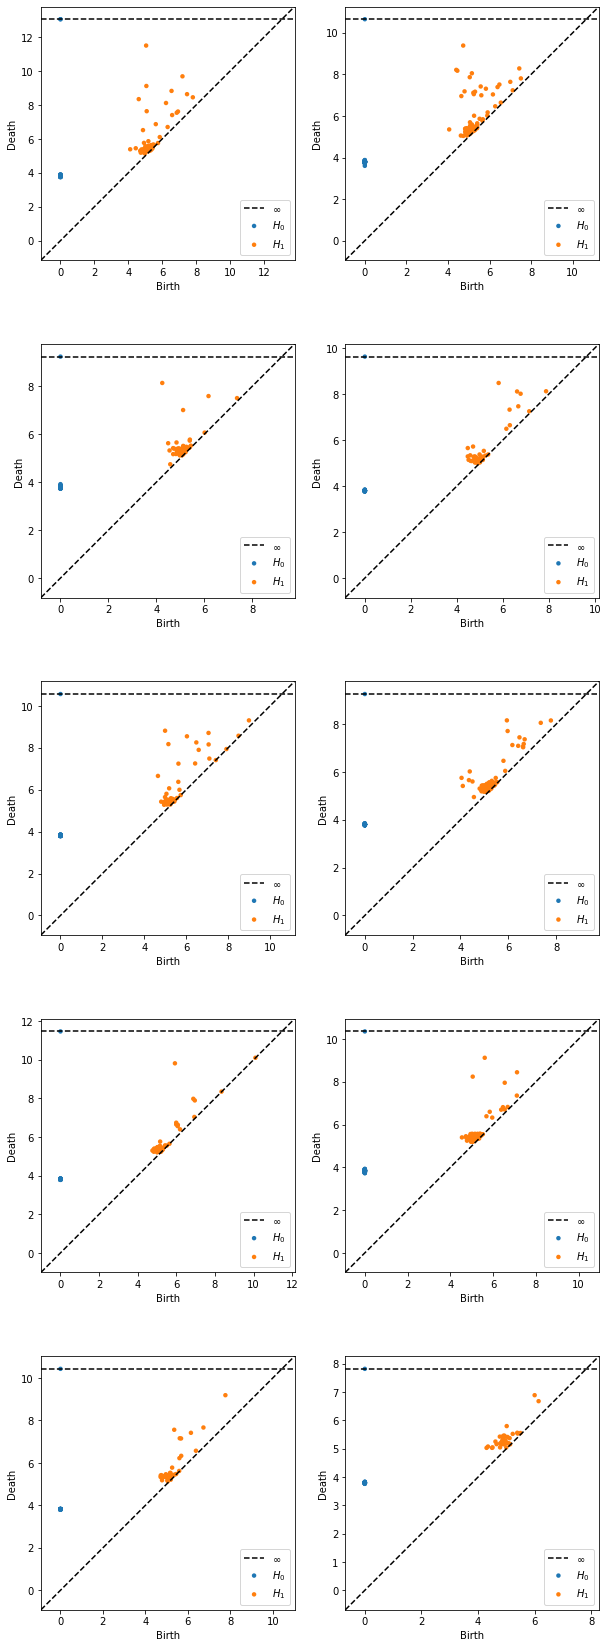

In [23]:
a = 5
b = 2
N= a*b
fig = plt.figure(figsize = (10,30))
plt.tight_layout()

for i in range(N):
    ax = fig.add_subplot(a, b, i+1)
    rips.plot(d['all_alphas'][all_alphas[i]])

### All beta

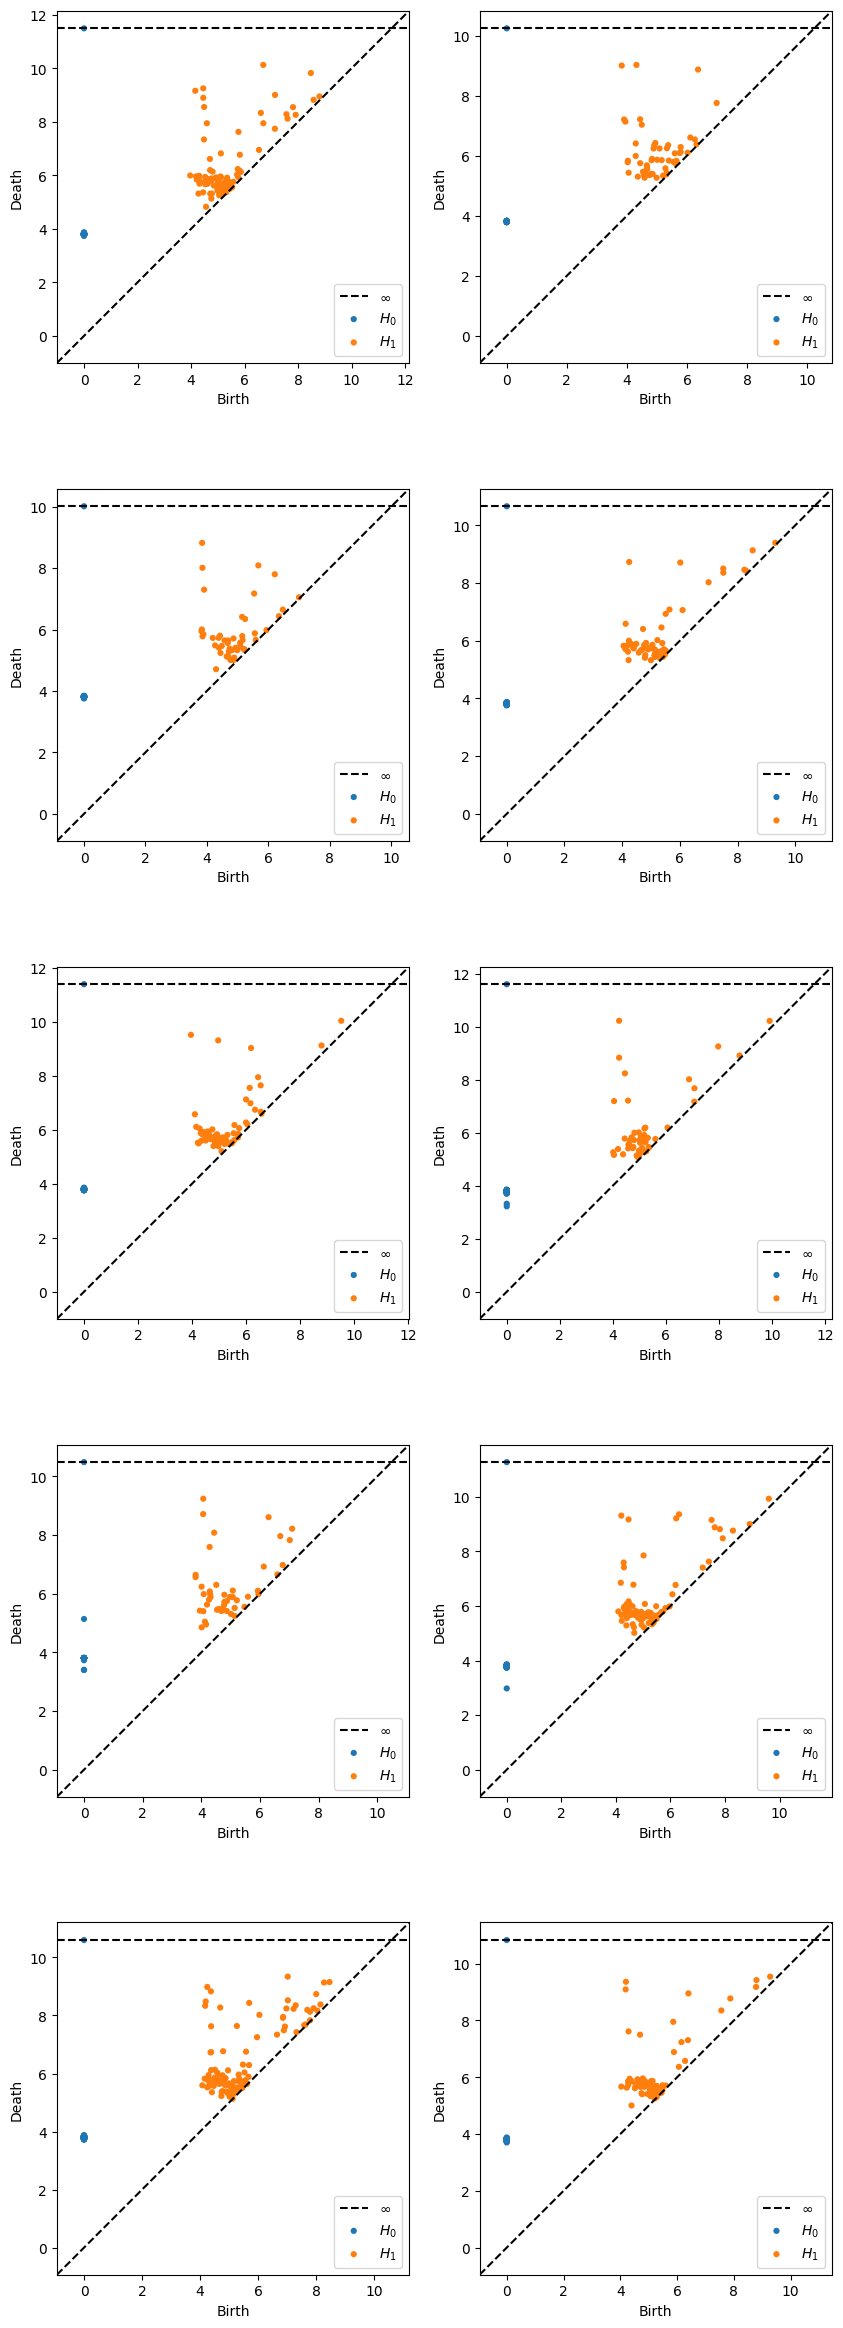

In [24]:
a = 5
b = 2
N= a*b
fig = plt.figure(figsize = (10,30))
plt.tight_layout()

for i in range(N):
    ax = fig.add_subplot(a, b, i+1)
    rips.plot(d['all_betas'][all_betas[i]])

### Alpha & beta


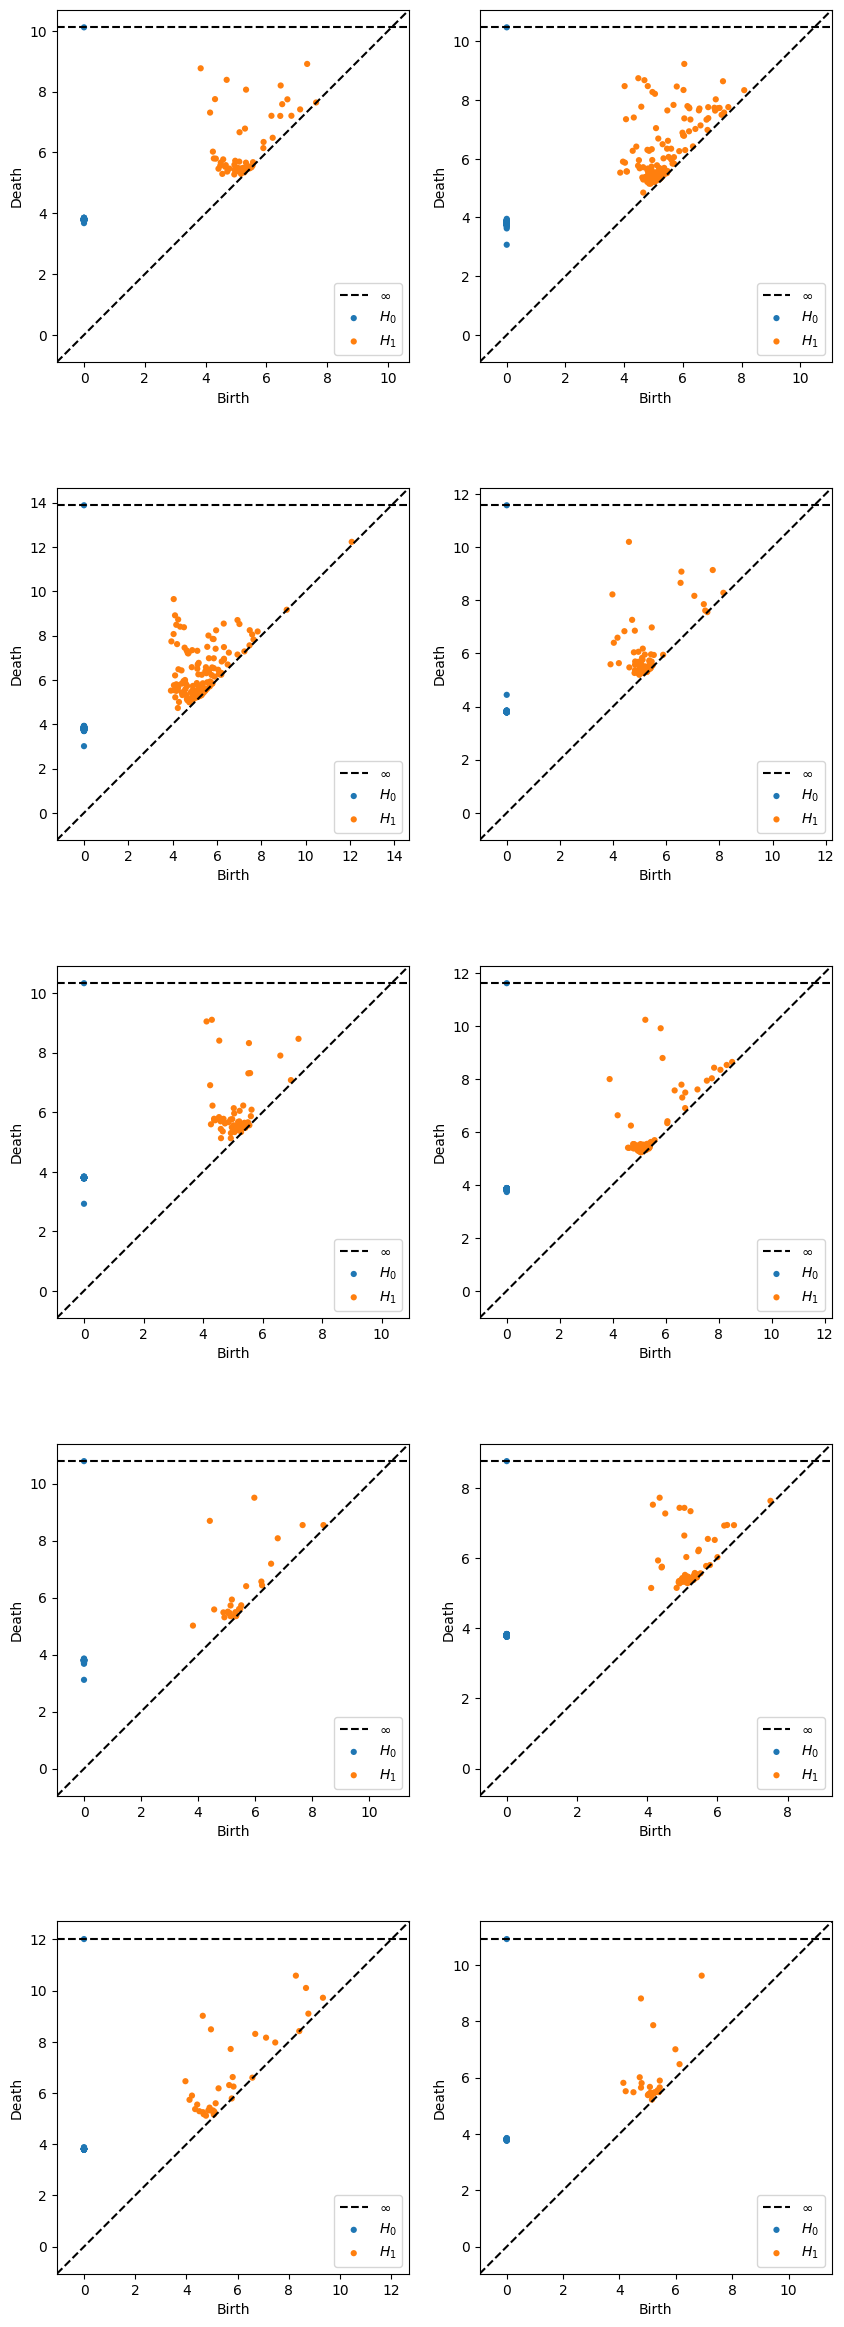

In [25]:
a = 5
b = 2
N= a*b
fig = plt.figure(figsize = (10,30))
plt.tight_layout()

for i in range(N):
    ax = fig.add_subplot(a, b, i+1)
    rips.plot(d['alpha_beta'][alpha_beta[i]])

### Feature engineering

#### **Descripción de los features**
- The length of the second longest **Betti 0** bar.
- The length of the third longest **Betti 0** bar.
- The summation of lengths of all **Betti 0** bars except for those exceed the max filtration value.
- The average length of **Betti 0** bars except for those exceed the max filtration value.
- The onset value of the longest **Betti 1** bar.
- The length of the longest **Betti 1** bar.
- The smallest onset value of the **Betti 1** bar that is longer than 1.5Å.
- The average of the middle point values of all the **Betti 1** bars that are longer than 1.5Å.
- The number of **Betti 1** bars that locate at [4.5, 5.5]Å, divided by the number of atoms.
- The number of **Betti 1** bars that locate at [3.5, 4.5)Å and (5.5, 6.5]Å, divided by the number of atoms.
- The summation of lengths of all the **Betti 1** bars except for those exceed the max filtration value.
- The average length of **Betti 1** bars except for those exceed the max filtration value.
- The onset value of the first **Betti 2** bar that ends after a given number.

In [16]:
all_proteins = list(d['all_alphas'].keys()) +  list(d['all_betas'].keys()) + list(d['alpha_beta'].keys())

In [17]:
labels = ['all alpha' for x in range(len(d['all_alphas'].keys()))] + ['all beta' for x in range(len(d['all_betas'].keys()))] + ['alpha beta' for x in range(len(d['alpha_beta'].keys()))]

In [18]:
data = pd.DataFrame({'Protein': all_proteins, 'Second structure': labels})

In [39]:
sec_longest_b0 = []
thi_longest_b0 = []
sum_b0 = []
mean_b0 = []
onset_longest_b1 = []
length_longest_b1 = []
smallest_onset_b1 = []
average_middle_b1 = []
sum_b1 = []
mean_b1 = []
b1_segment = []
b1_out_segment = []

for i in range(len(class_proteins)):
    for protein in d[name_class[i]].keys():
        dgm = d[name_class[i]][protein]
        atoms = N_atoms[name_class[i]][protein]
        if dgm[0][dgm[0][:, 1]<10000].sum()>1:
            sec_longest_b0.append(dgm[0][dgm[0][:, 1]<10000][-2][1])
        else:
            sec_longest_b0.append(0)
        if dgm[0][dgm[0][:, 1]<10000].sum()>2:
            thi_longest_b0.append(dgm[0][dgm[0][:, 1]<10000][-3][1])
        else:
            thi_longest_b0.append(0)
        if dgm[0][dgm[0][:, 1]<10000].sum()>0:
            sum_b0.append(dgm[0][dgm[0][:, 1]<10000].sum())
            mean_b0.append(dgm[0][dgm[0][:, 1]<10000].mean())
        else:
            sum_b0.append(0)
            mean_b0.append(0)
        if len(dgm[1])>1:
            onset_longest_b1.append(dgm[1][-1][0])
            length_longest_b1.append(dgm[1][-1][1]-dgm[1][-1][0])
        else: 
            onset_longest_b1.append(0)
            length_longest_b1.append(0)
        if len(dgm[1])>0:
            smallest_onset_b1.append(dgm[1][:,0].min())
            average_middle_b1.append(((dgm[1][:, 1]-dgm[1][:, 0])/2).mean())
            sum_b1.append((dgm[1][:, 1]-dgm[1][:, 0]).sum())
            mean_b1.append((dgm[1][:, 1]-dgm[1][:, 0]).mean())
            b1_segment.append((((dgm[1][:, 1]<=5.5) & (dgm[1][:, 0]>=4.5)).sum())/atoms)
            b1_out_segment.append((((dgm[1][:, 1]<=6.5) & (dgm[1][:, 0]>5.5)).sum() + (((dgm[1][:, 1]<4.5) & (dgm[1][:, 0]>=3.5)).sum()))/atoms)
        else:
            smallest_onset_b1.append(0)
            average_middle_b1.append(0)
            sum_b1.append(0)
            mean_b1.append(0) 
            b1_segment.append(0)
            b1_out_segment.append(0)
        
            

In [40]:
features = [sec_longest_b0, thi_longest_b0, sum_b0, mean_b0, onset_longest_b1, length_longest_b1, smallest_onset_b1, average_middle_b1, sum_b1, mean_b1, b1_segment, b1_out_segment] 
feature_names = ['sec_longest_b0', 'thi_longest_b0', 'sum_b0', 'mean_b0', 'onset_longest_b1', 'length_longest_b1', 'smallest_onset_b1', 'average_middle_b1', 'sum_b1', 'mean_b1', 'b1_segment', 'b1_out_segment'] 

for i in range(len(features)):
    print(feature_names[i])
    data[feature_names[i]] = features[i]

sec_longest_b0
thi_longest_b0
sum_b0
mean_b0
onset_longest_b1
length_longest_b1
smallest_onset_b1
average_middle_b1
sum_b1
mean_b1
b1_segment
b1_out_segment


In [41]:
data.head()

,Protein,Second structure,sec_longest_b0,thi_longest_b0,sum_b0,mean_b0,onset_longest_b1,length_longest_b1,smallest_onset_b1,average_middle_b1,sum_b1,mean_b1,b1_segment,b1_out_segment
0,d1ux8a_,all alpha,3.886905,3.873552,446.455619,1.907930,4.107818,1.276913,4.107818,0.307563,52.900820,0.615126,0.470588,0.025210
1,d3p4pb2,all alpha,3.857542,3.852336,519.228437,1.894994,4.059112,1.292687,4.059112,0.322592,55.485787,0.645184,0.369565,0.043478
2,d1grja1,all alpha,3.886075,3.868093,292.695404,1.900620,4.247597,3.893550,4.247597,0.209346,23.028028,0.418691,0.564103,0.012821
3,d2zjrv1,all alpha,3.841388,3.828285,246.885738,1.899121,4.474326,0.813355,4.474326,0.223770,19.244181,0.447539,0.454545,0.015152
4,d2qwob_,all alpha,3.852843,3.851204,347.717322,1.910535,4.651102,2.006509,4.651102,0.258503,36.707418,0.517006,0.434783,0.043478


Armamos un clasificador de la estructura secundaria de las proteinas a partir de las características geométricas extraidas a partir de sus diagramas de persistencia asociados.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_names], data['Second structure'], test_size=0.2)
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
print(np.mean(RF.predict(X_test) == y_test))

0.8502994011976048


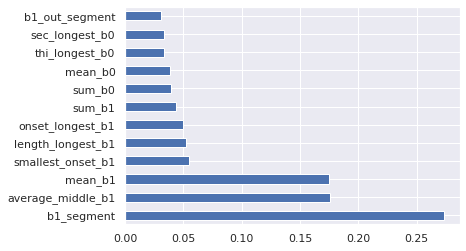

In [70]:
import seaborn as sns
sns.set()
feat_importances = pd.Series(RF.feature_importances_, index=feature_names)
feat_importances.nlargest(len(feature_names)).plot(kind='barh')


Confusion matrix, without normalization
[[64  0  5]
 [ 0 49  6]
 [ 7  7 29]]
Normalized confusion matrix
[[0.92753623 0.         0.07246377]
 [0.         0.89090909 0.10909091]
 [0.1627907  0.1627907  0.6744186 ]]


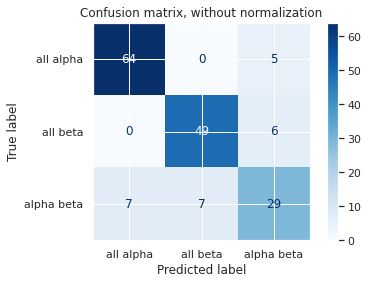

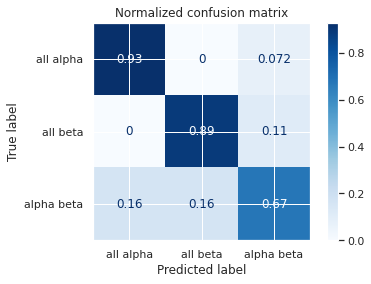

In [81]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(RF, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [216]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(data[feature_names], data['Second structure'], test_size=0.2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

SVM = svm.SVC()
SVM.fit(X_train, y_train)
print(np.mean(SVM.predict(X_test) == y_test))

0.7784431137724551


In [253]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(objective='multiclass', learning_rate = 0.005)

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
print(np.mean(y_pred == y_test))

0.7844311377245509
